# Recuperación de información con modelo neuronal

Con base en el modelo del espacio vectoria, la recuperación de información puede representar los documentos y los términos como vectores. Estos vectores pueden aprenderse por medio de redes neuronales, en lo que se conoce como <b>embeddings</b>.

Presentamos una forma de representar estos documentos y términos para un modelo de RI con base en el aprendizaje de embeddings a partir de una red FeedForward.

In [1]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import brown
from nltk.stem import SnowballStemmer
from collections import defaultdict, Counter
from itertools import chain
from pickle import dump, load
from operator import itemgetter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Preparación del dataset

Utilizamos el corpus Brown, que obtenemos a aprtir de NLTK. De este corpus obtenemos los documentos y los términos que componen a cada documentos.

In [2]:
#Stopwords
paro = stopwords.words('english')
#Documentos de los tópicos considerados
ids = brown.fileids(categories=['romance', 'religion']) #, 'reviews','romance','news'])
#Stemmer
stemmer = SnowballStemmer('english')

In [3]:
#Guarda las palabras
BagOfWords = defaultdict(list)
for i in ids:
    #Genera las palabras de cada documento
    words = brown.words(i)
    for w in words:
        #Aplica stopwords
        if w in paro or w.isalpha() == False:
            pass
        else:
            #Aplica stemmer y guarda
            BagOfWords[i].append(stemmer.stem(w))

print(BagOfWords.keys())

dict_keys(['cd01', 'cd02', 'cd03', 'cd04', 'cd05', 'cd06', 'cd07', 'cd08', 'cd09', 'cd10', 'cd11', 'cd12', 'cd13', 'cd14', 'cd15', 'cd16', 'cd17', 'cp01', 'cp02', 'cp03', 'cp04', 'cp05', 'cp06', 'cp07', 'cp08', 'cp09', 'cp10', 'cp11', 'cp12', 'cp13', 'cp14', 'cp15', 'cp16', 'cp17', 'cp18', 'cp19', 'cp20', 'cp21', 'cp22', 'cp23', 'cp24', 'cp25', 'cp26', 'cp27', 'cp28', 'cp29'])


In [4]:
for i, words in BagOfWords.items():
    print("Documento: {} \tNúm palabras: {}".format(i, len(words)))

Documento: cd01 	Núm palabras: 991
Documento: cd02 	Núm palabras: 990
Documento: cd03 	Núm palabras: 1130
Documento: cd04 	Núm palabras: 996
Documento: cd05 	Núm palabras: 1068
Documento: cd06 	Núm palabras: 1053
Documento: cd07 	Núm palabras: 1037
Documento: cd08 	Núm palabras: 1048
Documento: cd09 	Núm palabras: 1182
Documento: cd10 	Núm palabras: 1079
Documento: cd11 	Núm palabras: 1021
Documento: cd12 	Núm palabras: 1105
Documento: cd13 	Núm palabras: 1036
Documento: cd14 	Núm palabras: 1111
Documento: cd15 	Núm palabras: 1159
Documento: cd16 	Núm palabras: 1029
Documento: cd17 	Núm palabras: 1113
Documento: cp01 	Núm palabras: 1076
Documento: cp02 	Núm palabras: 1036
Documento: cp03 	Núm palabras: 1038
Documento: cp04 	Núm palabras: 1140
Documento: cp05 	Núm palabras: 1040
Documento: cp06 	Núm palabras: 1101
Documento: cp07 	Núm palabras: 1054
Documento: cp08 	Núm palabras: 1081
Documento: cp09 	Núm palabras: 909
Documento: cp10 	Núm palabras: 1063
Documento: cp11 	Núm palabras: 1

Para entrenar la red neuronal y general las representaciones vectoriales generamos pares de entrenamiento, estos pares son de la forma:

$$(d_i, t_j)$$

Es decir, el documento será la entrada de la red y el término la salida. Por lo que se tendrá que estimar una probabilidad de la forma $p(t_j|d_i)$.

Al estimar esta probabilidad el método aprenderá las representaciones vectoriales tanto de los documentos como de los términos.

In [5]:
#Frecuencia de términos
freqs = Counter(list(chain(*BagOfWords.values())))
#Índices para términos
idx = {w:k for k,w in enumerate(freqs.keys())}
#Índices para documentos
docs = {d:l for l,d in enumerate(BagOfWords.keys())}

In [6]:
#Guarda pares de entrenamiento
pairs = []
for doc, words  in BagOfWords.items():
    #Genera los pares (d_i, w_j)
    pairs.append([(docs[doc], idx[wk]) for wk in words])
    
pairs = list(chain(*pairs))
print(len(pairs))
print(pairs[:10])

49194
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9)]


### Red neuronal

La red neuronal es una red FeedForward que toma como entrada los documentos y obtiene como salida las probabilidades de los términos dado los documentos. 

La red toma solamente dos capas: 1) la capa en que se aprenden las representaciones de los documentos; y 2) la capa de salida que aprende las representaciones de los términos. Estas capas son completamente lineales y no tienen bias ni función de activación. 

De tal forma que, si $u_i$ es el vector del documento $d_i$ que entra y $w_j$ es el vector del término $t_j$, entonces la probabilidad de salida se estima como:

$$p(t_j|d_i) = \frac{exp\{u_i \cdot w_j\}}{\sum_k exp\{u_i \cdot w_k\}}$$

In [17]:
np.random.seed(0)
#El número de rasgos que representan cada vector
input_dim = len(docs)
#El total de clases que arrojará
output_dim = len(idx)
#El número de ejmplos
#num_examples = len(bigrams)

#Dimensiones de los vectores-palabra
dim = 2

#Embedding
U = np.random.randn(dim, input_dim) / np.sqrt(input_dim)

#Capa de salida
W = np.random.randn(output_dim,dim) / np.sqrt(dim)

print(U.shape)
print(W.shape)

(2, 46)
(6961, 2)


Para entrenar la red usamos retropropagación y gradiente descendiente estocástico. La función de riesgo es la entropía cruzada.

In [8]:
%%time

entropy = []
its = 20
eta = 0.1
for i in range(0,its):
    H = 0.0
    for ex in pairs:
        #Forward
        #Embedimiento
        u_w = U.T[ex[0]]
        #salida
        a = np.dot(W,u_w)
        out = np.exp(a - np.max(a))
        #Softmax
        f = out/out.sum(0)
        H1 = np.log(f)[ex[1]]
        H -= H1

        #Backprop
        #Variable de salida
        d_out = f
        d_out[ex[1]] -= 1
        
        #Variable de embedding
        d_emb = np.dot(d_out,W)
        
        #Actualizacion de salida
        W -= eta*np.outer(d_out,u_w)

        #Actualizacion de embedding
        U.T[ex[0]] -= eta*d_emb

        #Entropia cruzada
        k = int(ex[1])

    entropy.append(H)   
    print('Fin de la iteración',i, 'entropía', H)

Fin de la iteración 0 entropía 402450.8194443338
Fin de la iteración 1 entropía 380495.7191362397
Fin de la iteración 2 entropía 376516.3056647496
Fin de la iteración 3 entropía 373615.93680705724
Fin de la iteración 4 entropía 371126.8317958111
Fin de la iteración 5 entropía 369532.5353079679
Fin de la iteración 6 entropía 368566.5247294065
Fin de la iteración 7 entropía 367936.8934264946
Fin de la iteración 8 entropía 367497.8469726899
Fin de la iteración 9 entropía 367176.8891816671
Fin de la iteración 10 entropía 366933.7669659583
Fin de la iteración 11 entropía 366744.03249862127
Fin de la iteración 12 entropía 366592.18409935053
Fin de la iteración 13 entropía 366468.08582301694
Fin de la iteración 14 entropía 366364.87531686143
Fin de la iteración 15 entropía 366277.7489112969
Fin de la iteración 16 entropía 366203.2451181616
Fin de la iteración 17 entropía 366138.8090923645
Fin de la iteración 18 entropía 366082.51901058375
Fin de la iteración 19 entropía 366032.9068167674
CPU 

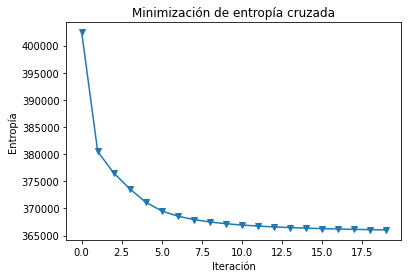

In [9]:
plt.plot(entropy, 'v-')
plt.xlabel('Iteración')
plt.ylabel('Entropía')
plt.title('Minimización de entropía cruzada')
plt.show()

### Resultados de la red

Finalmente tenemos un modelo entrenado que podemos visualizar y con el que podemos trabajar; esto es, realizar consultas. Podemos ver como trabaja este modelo.

In [12]:
#Guarda el modelo aprendido
#fname = open('NeuralModel.p','wb')
#dump((Docs, Terms, docs, idx), fname)
#fname.close()

In [13]:
#Carga el modelo guardado
fname = open('NeuralModel.p','rb')
Docs, Terms, docs, idx = load(fname)
fname.close()

En primer lugar, podemos visualizar los embeddings aprendidos para ver cómo se comporta el espacio vectorial.

In [18]:
#Funcion para plotear los datos con labels
def plot_words(Z,ids,color='blue'):
    #Reduce la dimensionalidad a 2
    #Z = PCA(2).fit_transform(Z)
    
    #Plotea con la marcas (marker) y el color indicado (c)
    r=0
    plt.scatter(Z[:,0],Z[:,1], marker='o', c=color)
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1

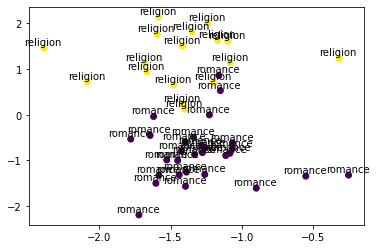

In [19]:
#Ordena las etiquetas para que coincidan con los vectores-renglón de la matriz de embedding
label = [brown.categories(w[0])[0] for w in sorted(docs.items(), key=itemgetter(1))]

plot_words(Docs,label,color=[1*(l=='religion') for l in label])
plt.show()

También podemos ver los contenidos de los vectores según su tópico.

In [20]:
#Ver los contenidos
cod = pd.DataFrame(data=Docs, index=label, columns=['X','Y'])
cod.T

,religion,religion,religion,religion,religion,religion,religion,religion,religion,religion,...,romance,romance,romance,romance,romance,romance,romance,romance,romance,romance
X,-1.666211,-1.348313,-1.238009,-1.583626,-1.198853,-2.389104,-1.478740,-1.096978,-1.593371,-1.168524,...,-1.439589,-1.082678,-1.526704,-0.548831,-1.722854,-1.226751,-1.395250,-1.339090,-1.282947,-1.064352
Y,0.937589,1.805673,2.001844,2.126461,0.705419,1.456108,0.644995,1.602612,1.754179,1.617647,...,-1.317446,-0.845847,-0.992333,-1.345761,-2.192895,-0.007463,-1.567472,-0.496672,-0.681054,-0.619128


Asimismo, podemos visualizar los términos o consultas dentro del espacio vectorial.

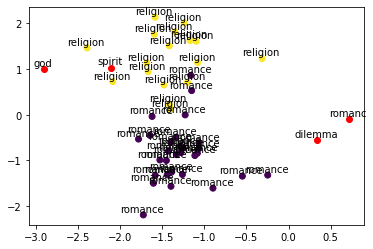

In [21]:
query = Terms[ [idx['spirit'], idx['god'], idx['romanc'], idx['dilemma']] ] 
plot_words(query,['spirit','god', 'romanc', 'dilemma'],color='r')
plot_words(Docs,label,color=[1*(l=='religion') for l in label])
plt.show()

Finalmente, podemos usar alguna medida de similitud para estimar la cercanía de una query al connjunto de documentos. De esta forma, podremos realizar consultas con este modelo:

In [22]:
def sim(query, doc, metric='euc', p=2):
    t_vec = np.array([Terms[idx[w]] for w in query]).sum(0)
    #print(t_vec)
    d_vec = Docs[docs[doc]]
    
    if metric == 'euc':
        return 1/np.linalg.norm(t_vec-d_vec)
    if metric == 'cos':
        return np.abs( np.dot(t_vec,d_vec) )/( np.linalg.norm(t_vec)*np.linalg.norm(d_vec) ) 
    if metric == 'NOT':
        s = (t_vec**p)@(d_vec**p)/(t_vec**p).sum()
        return 1-s**(1/p)
    elif metric == 'AND':
        s = (t_vec**p)@(1-d_vec**p)/(t_vec**p).sum()
        return 1 - np.abs(s)**(1/p)
    elif metric == 'OR':
        s = (t_vec**p)@(d_vec**p)/(t_vec**p).sum()
        return s**(1/p)
    
def consult(query, metric='euc'):
    query = [stemmer.stem(w.lower()) for w in query]
    for d in docs.keys():
        s = sim(query, d, metric=metric)

        yield s,d,brown.categories(d)[0]

In [26]:
results = consult(['dilemma'])
for s, doc, topic in sorted(results, key=itemgetter(0), reverse=True):
    print(topic, doc, s)

romance cp09 1.0423873017491312
romance cp23 0.844900129397543
romance cp29 0.7107829673468591
romance cp05 0.7049112012711242
romance cp21 0.688961489942748
romance cp06 0.6710255895263777
romance cp11 0.6230341469507286
romance cp13 0.6176950074230535
romance cp28 0.6140388949549522
romance cp18 0.6099739706145907
romance cp25 0.6006820061486522
romance cp27 0.594508829386484
romance cp01 0.5878964233966325
romance cp08 0.5750029453673065
romance cp03 0.5665511125776489
romance cp04 0.5614830158071611
romance cp12 0.542223905449284
romance cp17 0.5413813423071231
romance cp16 0.5367537568295199
religion cd13 0.5343570912447138
religion cd14 0.5244874601684975
romance cp22 0.5218440166435289
religion cd17 0.519485689896705
romance cp20 0.5172849333818106
romance cp14 0.5028286138526117
religion cd05 0.5006736049058816
romance cp26 0.4987882194848493
romance cp10 0.4926803008752681
romance cp07 0.48353092045446006
romance cp15 0.4834425180455873
romance cp19 0.47127739657829926
romance